In [127]:

import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import random
import math
import copy

In [128]:
df = pd.read_csv('city.csv')
df = df.sort_values(by='population', ascending=False)
df = df.head(30)
df = df[['address', 'geo_lat', 'geo_lon']]
df

,address,geo_lat,geo_lon
509,г Москва,55.754047,37.620405
786,г Санкт-Петербург,59.939131,30.315900
647,г Новосибирск,55.028191,82.921149
832,г Екатеринбург,56.838522,60.605491
619,г Нижний Новгород,56.324063,44.005391
927,г Казань,55.794358,49.111497
782,г Самара,53.195031,50.106952
656,г Омск,54.984857,73.367452
1064,г Челябинск,55.160262,61.400808
757,г Ростов-на-Дону,47.222457,39.718803


The map with the top 30 cities by population in Russia.

C:\Users\sasha\AppData\Local\Temp\ipykernel_8516\1387521904.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


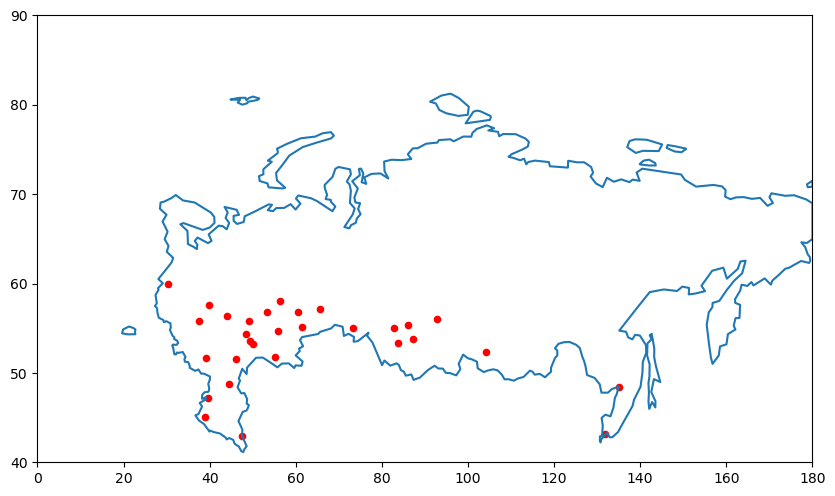

In [129]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
russia = world[world.name == 'Russia']
fig, ax = plt.subplots(figsize=(10, 10))
russia.boundary.plot(ax=ax)
plt.scatter(df.geo_lon, df.geo_lat, color='red', s=20)
plt.xlim(0, 180)
plt.ylim(40, 90)
plt.show()


Formula for calculating the distance between two points on the Earth's surface
Reference: [https://en.wikipedia.org/wiki/Great-circle_distance](https://en.wikipedia.org/wiki/Great-circle_distance)

$\Delta \sigma = \arccos(\sin(\varphi_1) \cdot \sin(\varphi_2) + \cos(\varphi_1) \cdot \cos(\varphi_2) \cdot \cos(\Delta \lambda))$\
$d = R \Delta \sigma$

where:
- $\Delta \sigma$ - central angle between the two points
- $\varphi_1, \varphi_2$ - latitudes of the two points
- $\Delta \lambda$ - difference in longitudes of the two points
- $R$ - mean radius of the Earth
- $d$ - distance between the two points


In [130]:
def distance_2p(city1, city2):
    R = 6371  # mean radius of the earth in km
    lat1 = math.radians(city1[0])
    lon1 = math.radians(city1[1])
    lat2 = math.radians(city2[0])
    lon2 = math.radians(city2[1])
    lon = lon2 - lon1
    central_angle = math.acos(math.sin(lat1) * math.sin(lat2) + math.cos(lat1) * math.cos(lat2) * math.cos(lon))
    d = R * central_angle
    return d

Simulated annealing with the Travelling Salesman Problem with the cost function as the total distance of the path.

cost_function: $dist_p(x) = h(x) = E(x) = \sum_{i=1}^{N} dist(cities[i-1], cities[i])$

proportional function: $p*(x) = exp(\frac{-h(x)}{T})$

acceptance ratio: $\alpha = \frac{p*(x')}{p*(x_t)} = \frac{exp(\frac{-h(x')}{T})}{exp(\frac{-h(x_t)}{T})} = exp(\frac{(h(x_t) - h(x'))}{T}) = exp(\frac{(dist_p(x_t) - dist_p(x'))}{T})$, if $dist_p(x_t) - dist_p(x') < 0$
$\alpha = 1$ otherwise, to handle cases, where acceptance ratio will be greater than 1 and possibly will go to infinity.

where:

where
- $x'$ - candidate solution
- $x_t$ - current solution
- $T$ - temperature
- $dist_p(x)$ - total distance of the path
- $dist(cities[i-1], cities[i])$ - distance between two cities
- $E(x)$ - energy function
- $N$ - number of cities
- $cities$ - list of cities

Generating a candidate solution was implemented the same way as in NIC 10th lab:
1. Randomly select two distinct cities
2. Reverse the order of the cities between them

This approach has shown better results than a simple swap of two random cities.

In [131]:
def create_dist_matrix(cities):
    """
    Create a distance matrix for all cities
    :param cities: list of cities
    :return: distance matrix
    """
    N = len(cities)
    dist_matrix = np.zeros((N, N))
    for i in range(N):
        for j in range(i, N):
            dist_matrix[i][j] = distance_2p(cities[i], cities[j])
            dist_matrix[j][i] = dist_matrix[i][j]
    return dist_matrix


class SA_TSP:
    def __init__(self, cities, T, anneal_rate, stopping_iter, stopping_T):
        # 1 step. Sample initial x0, set time step t = 0;
        self.cities = cities
        self.N = len(cities)
        self.cur_solution = self.initial_solution()
        self.iter = 0

        # 2 step. Set initial temperature T, anneal rate, stopping iteration and temperature
        self.T = T
        self.anneal_rate = anneal_rate
        self.stopping_iter = stopping_iter
        self.stopping_T = stopping_T

        # distance matrix
        self.dist_matrix = create_dist_matrix(cities)

        # lists for visualization
        self.best_solution = self.cur_solution
        self.cur_dist = self.distance(self.cur_solution)
        self.best_dist = self.cur_dist
        self.dist_list = [self.cur_dist]
        self.best_list = [self.best_dist]
        self.cur_solution = self.best_solution
        self.cur_dist = self.best_dist
        self.acceptance_list = []
        self.temperature_list = [self.T]

    def initial_solution(self):
        """
        Generate a random initial solution
        :return: list of cities
        """
        solution = list(range(self.N))
        random.shuffle(solution)
        return solution

    def distance(self, sol):
        """
        Calculate the total distance of the path
        :param sol: list of cities
        :return: total distance
        """
        dist = 0
        for i in range(self.N):
            dist += self.dist_matrix[sol[i - 1]][sol[i]]
        return dist

    def generate_candidate(self):
        """
        3 step. Generate x with chosen proposal policy:
        pick two points and reverse the order of the cities between them
        :return: candidate solution
        """
        candidate = copy.deepcopy(self.cur_solution)
        l = random.randint(2, self.N - 1)
        i = random.randint(0, self.N - l)
        candidate[i:(i + l)] = reversed(candidate[i:(i + l)])
        return candidate

    def alpha(self, candidate):
        """
        4 step. Calculate acceptance ratio α = p∗(x′)/p∗(x_t);
        :param candidate: 
        :return: acceptance ration
        """
        candidate_dist = self.distance(candidate)
        return math.exp((self.cur_dist - candidate_dist) / self.T) if self.cur_dist - candidate_dist < 0 else 1

    def accept(self, candidate):
        """
        5 step. Accept the candidate solution with the probability p_accept
        :param candidate: the new solution to be evaluated
        :return: None
        """
        candidate_dist = self.distance(candidate)
        if random.random() <= self.alpha(candidate):
            self.cur_dist = candidate_dist
            self.cur_solution = candidate
            if candidate_dist < self.best_dist:
                self.best_dist = candidate_dist
                self.best_solution = candidate

    def annealing(self):
        """
        8 step. Repeat 2-7 steps until cooled down.
        """
        while self.T >= self.stopping_T and self.iter < self.stopping_iter:
            # 3 step. Generate x with chosen proposal policy
            candidate = self.generate_candidate()
            # 4 step. Calculate acceptance ratio α = p∗(x′)/p∗(xt);
            # 5 step. Accept the candidate solution with the probability p_accept
            self.accept(candidate)
            # update values
            self.dist_list.append(self.cur_dist)
            self.best_list.append(self.best_dist)
            self.temperature_list.append(self.T)
            self.acceptance_list.append(self.alpha(candidate))
            # 6. Reduce temperature T by the annealing rate
            self.T *= self.anneal_rate
            # 7. Increment t;
            self.iter += 1

        print('Best solution:', self.best_solution)
        print('Number of iterations:', self.iter)
        print('Initial temperature:', self.temperature_list[0])
        print('Final temperature:', self.temperature_list[-1])
        print('Initial best distance:', self.best_list[0])
        print('Final best distance:', self.best_list[-1])
        fig, ax = plt.subplots(1, 2, figsize=(15, 5))
        ax[0].plot(range(len(self.best_list)), self.best_list, label='Best distance')
        ax[0].legend()
        ax[0].title.set_text('Distance change')
        ax[0].x_label = 'Iteration'
        ax[0].y_label = 'Distance'
        ax[1].plot(range(len(self.temperature_list)), self.temperature_list, label='Temperature')
        ax[1].legend()
        ax[1].title.set_text('Temperature change')
        ax[1].x_label = 'Iteration'
        ax[1].y_label = 'Temperature'
        plt.show()

    def plot_solution_geo(self):
        """
        Plot the best solution on the map
        """
        world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
        russia = world[world.name == 'Russia']
        fig, ax = plt.subplots(figsize=(10, 10))
        russia.boundary.plot(ax=ax)
        plt.scatter(self.cities[self.best_solution, 1], self.cities[self.best_solution, 0], color='red', s=20)
        for i in range(self.N - 1):
            plt.plot([self.cities[self.best_solution[i], 1], self.cities[self.best_solution[i + 1], 1]],
                     [self.cities[self.best_solution[i], 0], self.cities[self.best_solution[i + 1], 0]], color='blue')
        plt.plot([self.cities[self.best_solution[-1], 1], self.cities[self.best_solution[0], 1]],
                 [self.cities[self.best_solution[-1], 0], self.cities[self.best_solution[0], 0]], color='blue')
        plt.title('Best solution')
        plt.xlim(0, 180)
        plt.ylim(40, 90)
        plt.x_label = 'Longitude'
        plt.y_label = 'Latitude'
        plt.show()



Several initial temperatures were tested. At the end, the value equal to number of cities was chosen, as it gave acceptable results.

In [132]:
cities = df[['geo_lat', 'geo_lon']].values
T = 30
stopping_T = 0.0001

The algorithm was tested with the following values of annealing rate: 0.9, 0.99, 0.999 to compare the results.

Fast cooling: anneal_rate = 0.9

Best solution: [27, 2, 28, 23, 29, 21, 13, 26, 24, 18, 7, 12, 10, 11, 6, 3, 19, 17, 4, 20, 5, 22, 1, 0, 9, 14, 16, 15, 25, 8]
Number of iterations: 120
Initial temperature: 30
Final temperature: 0.00010764153393328546
Initial best distance: 61172.772893204055
Final best distance: 34536.48624452438


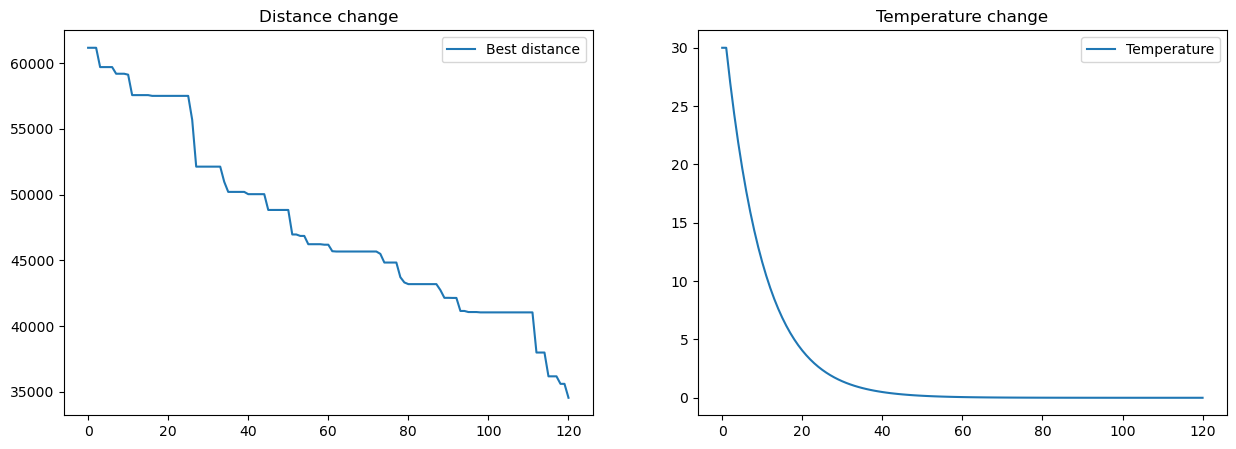

C:\Users\sasha\AppData\Local\Temp\ipykernel_8516\3269423906.py:142: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


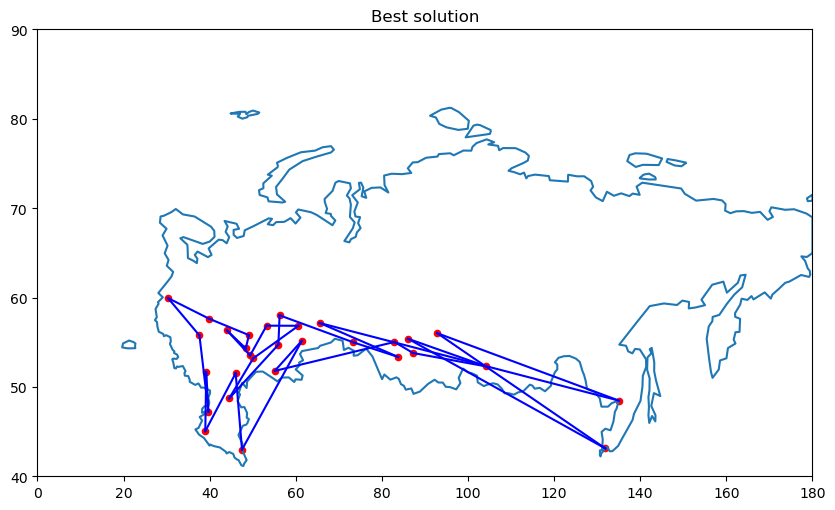

In [133]:
stopping_iter = 2000
anneal_rate = 0.9
tsp = SA_TSP(cities, T, anneal_rate, stopping_iter, stopping_T)
tsp.annealing()
tsp.plot_solution_geo()

Middle value: anneal_rate = 0.99

Best solution: [29, 2, 24, 3, 12, 19, 5, 0, 1, 22, 4, 14, 9, 16, 25, 11, 15, 20, 17, 6, 27, 10, 8, 7, 18, 28, 23, 21, 26, 13]
Number of iterations: 1255
Initial temperature: 30
Final temperature: 0.00010084521124493241
Initial best distance: 70037.60192249969
Final best distance: 18442.56718616668


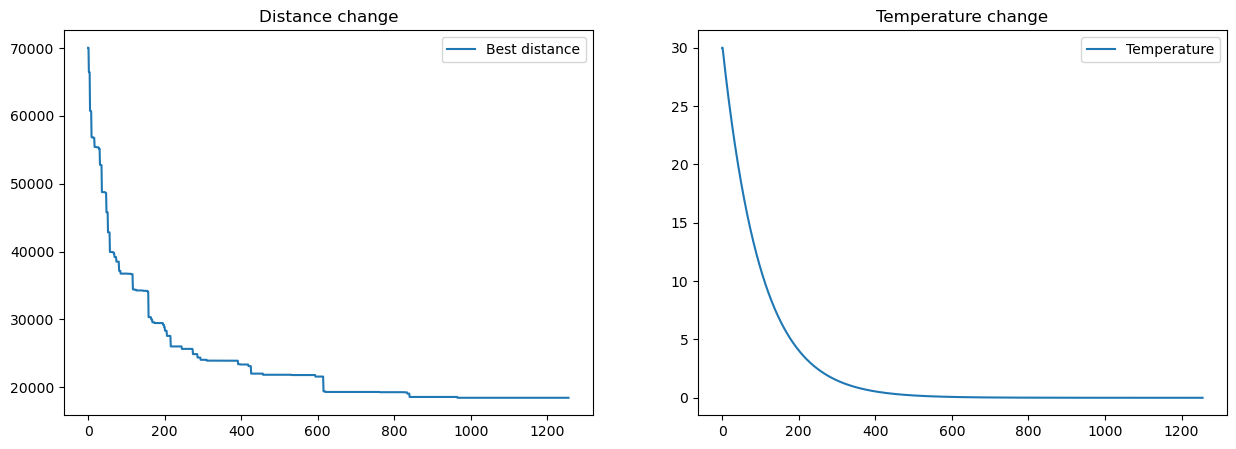

C:\Users\sasha\AppData\Local\Temp\ipykernel_8516\3269423906.py:142: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


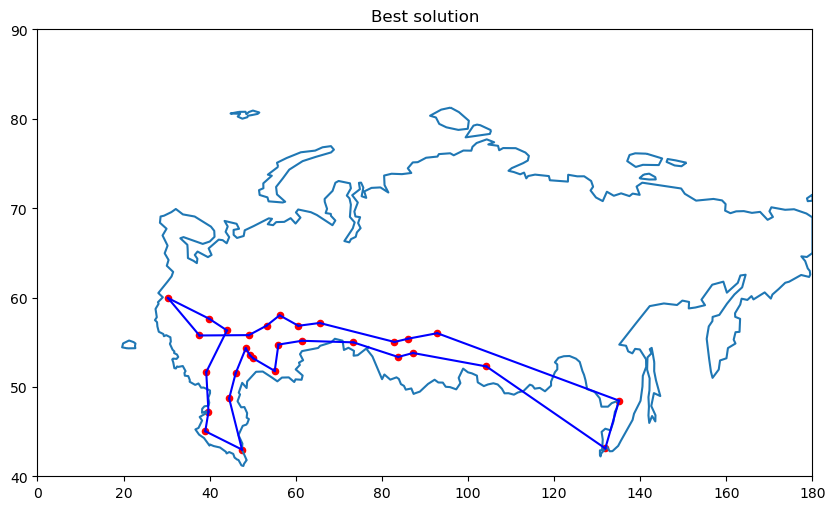

In [134]:
anneal_rate = 0.99
stopping_iter = 5000
tsp = SA_TSP(cities, T, anneal_rate, stopping_iter, stopping_T)
tsp.annealing()
tsp.plot_solution_geo()

Slow cooling: anneal_rate = 0.9995

Best solution: [16, 9, 14, 0, 1, 22, 4, 5, 19, 12, 3, 24, 2, 29, 13, 26, 21, 23, 28, 18, 7, 8, 10, 27, 6, 17, 20, 15, 11, 25]
Number of iterations: 20000
Initial temperature: 30
Final temperature: 0.0013592756560821127
Initial best distance: 66423.79783407459
Final best distance: 17907.82974585047


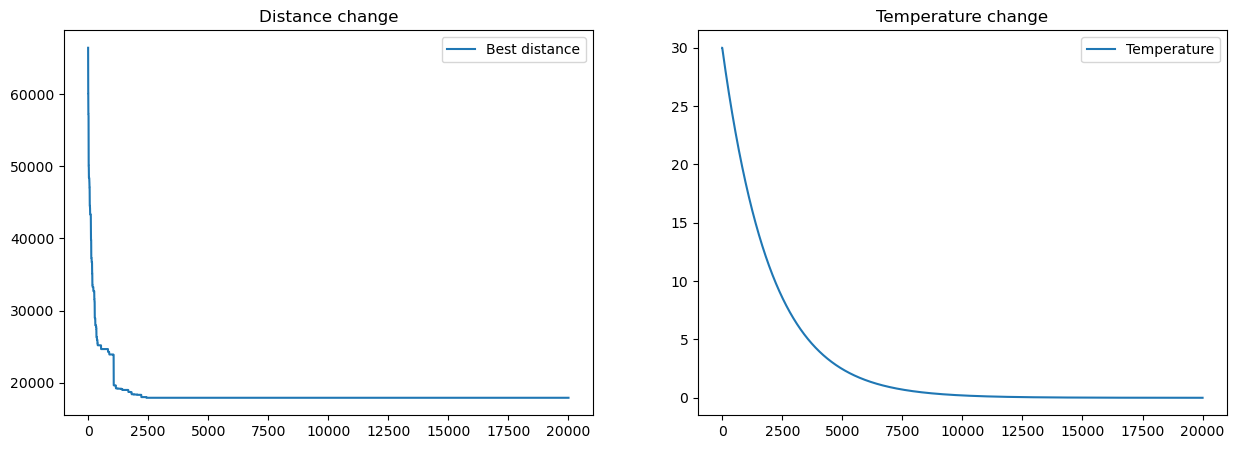

C:\Users\sasha\AppData\Local\Temp\ipykernel_8516\3269423906.py:142: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


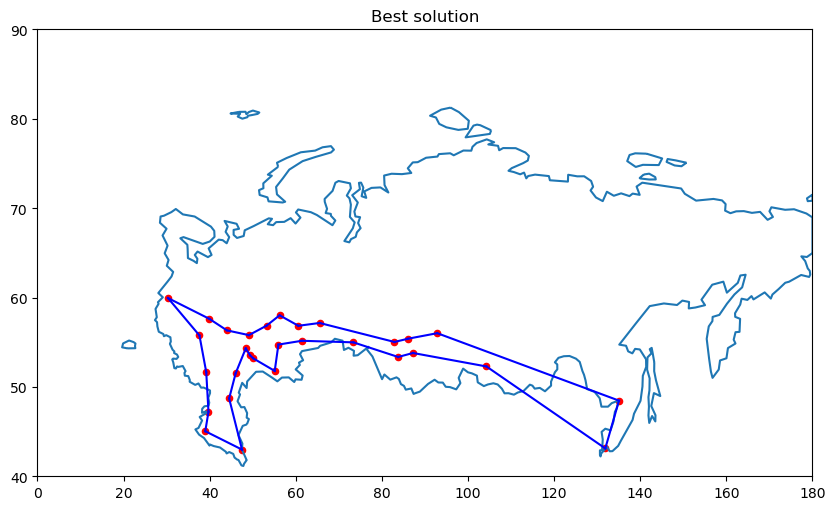

In [135]:
anneal_rate = 0.9995
stopping_iter = 20000
tsp = SA_TSP(cities, T, anneal_rate, stopping_iter, stopping_T)
tsp.annealing()
tsp.plot_solution_geo()

For the current problem, slowing down the cooling rate have a positive effect on the optimization result. It results in finding a better solution, but it requires more iterations to converge. 
The fast cooling rate gives a worse result, it stacks in a local minima. That indicates not enough exploration time for the problem. 
The middle value of annealing rate gives a good balance between the speed of convergence and the quality of the solution, resulting in distance close to slow cooling rate. 
The best solution in terms of optimal distance was found with the slow cooling rate annealing rate = 0.9995. Even though the temperature does not reach the 0, for a reasonable amount of iterations, we see that the cost function has reached the minimum. Since iterations are being computed fast enough and the speed of execution is not a problem, this value of is the best for the current problem. 

Additional theory sources
References: 
1. [https://en.wikipedia.org/wiki/Simulated_annealing
](https://en.wikipedia.org/wiki/Simulated_annealing)
2. NIC Lecture and Lab for Simulated Annealing